Nếu gặp lỗi thì hãy restart session rồi chạy lại (bỏ qua các pip install)

In [ ]:
! pip install torchvision==0.14.1

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [ ]:
! pip install transformers datasets
! pip install -q pytorchvideo transformers evaluate

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')


! kaggle datasets download -d haitonthat/data-afterprocess-p2

In [ ]:
!unzip "/content/data-afterprocess-p2.zip"

In [13]:
#Take access token write of account hugging face
from huggingface_hub import notebook_login

notebook_login()

In [1]:
import os

dataset_root = '/content/content/output'

all_video_file_paths = []

for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if 1:
            full_path = os.path.join(root, file)
            all_video_file_paths.append(full_path)
print(all_video_file_paths)

['/content/content/output/val/squat/squat_133.MOV', '/content/content/output/val/squat/squat_129.MOV', '/content/content/output/val/squat/squat_26.mp4', '/content/content/output/val/squat/squat_27.mp4', '/content/content/output/val/squat/squat_131.MOV', '/content/content/output/val/squat/squat_134.MOV', '/content/content/output/val/squat/squat_25.mp4', '/content/content/output/val/squat/squat_24.mp4', '/content/content/output/val/squat/squat_132.MOV', '/content/content/output/val/squat/squat_130.MOV', '/content/content/output/val/squat/squat_28.mp4', '/content/content/output/val/squat/squat_29.mp4', '/content/content/output/val/lateral raise/lateral_raise_32.mp4', '/content/content/output/val/lateral raise/lateral_raise_34.mp4', '/content/content/output/val/lateral raise/lateral_raise_35.mp4', '/content/content/output/val/lateral raise/lateral_raise_31.mp4', '/content/content/output/val/lateral raise/lateral_raise_37.mp4', '/content/content/output/val/lateral raise/lateral_raise_33.mp4

In [2]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['barbell biceps curl', 'bench press', 'chest fly machine', 'dbp', 'deadlift', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raise', 'leg extension', 'leg raises', 'plank', 'pull up', 'push-up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown'].


In [3]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base-finetuned-kinetics"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([22, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([22]) in the model instantiated
You should probably TRAIN this model on a d

In [4]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    RandomAffine,
    ColorJitter
)

In [12]:
mean = image_processor.image_mean
std = image_processor.image_std
# if "shortest_edge" in image_processor.size:
#     height = width = image_processor.size["shortest_edge"]
# else:
#     height = image_processor.size["height"]
#     width = image_processor.size["width"]
# resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
# sample_rate = 4
# fps = 30
# clip_duration = num_frames_to_sample * sample_rate / fps
clip_duration = 3

In [13]:
clip_duration

3

In [14]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # RandomShortSideScale(min_size=256, max_size=320),
                    # RandomCrop((224,224)),
                    # Resize((224,224)),
                    RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                    # ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
dataset_root_path = '/content/content/output'
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [15]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # Resize((224,224)),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

# test_dataset = pytorchvideo.data.Ucf101(
#     data_path=os.path.join(dataset_root_path, "test"),
#     clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
#     decode_audio=False,
#     transform=val_transform,
# )

In [16]:
print(train_dataset.num_videos, val_dataset.num_videos)

659 168


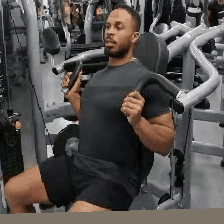

In [18]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 3}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

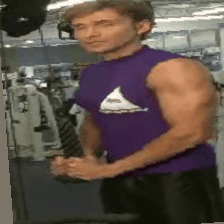

In [19]:
sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/sample_gif.gif" alt="Person playing basketball"/>
</div>

In [ ]:
! pip install -U accelerate
! pip install -U transformers

In [20]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.38.2', '0.28.0')

In [ ]:
import os
os._exit(00)

In [21]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-round2-v3"
num_epochs = 11
batch_size = 4
args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=9e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [ ]:
! pip install evaluate

In [22]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [23]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
import torch
trainer.evaluate()
# trainer.predict(test_dataset)

{'eval_loss': 0.5377120971679688,
 'eval_accuracy': 0.8672897196261682,
 'eval_runtime': 51.9166,
 'eval_samples_per_second': 10.305,
 'eval_steps_per_second': 2.581,
 'epoch': 10.09}

In [ ]:
import torch
# import accelerate
# from torch.utils.data import DataLoader
# accelerator = accelerate.Accelerator()
# train_dataloader = accelerator.prepare(DataLoader(train_dataset, **dataloader_params))
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.703600,1.047141,0.700549
1,0.468400,0.567789,0.821429
2,0.430100,0.702865,0.785714


In [ ]:
trainer.push_to_hub()

events.out.tfevents.1710500478.f44b39249e56.3956.0:   0%|          | 0.00/47.7k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bluebird089/videomae-base-finetuned-kinetics-finetuned-round2/commit/c58c395eb007e31dbbd816b10a46015bd305a0a4', commit_message='End of training', commit_description='', oid='c58c395eb007e31dbbd816b10a46015bd305a0a4', pr_url=None, pr_revision=None, pr_num=None)